<a href="https://colab.research.google.com/github/ValorXIV/ResNet_WeatherImageClassification/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import dependencies

In [ ]:
# Install opendatasets for downloading Kaggle data
!pip install opendatasets

# General imports
import opendatasets as od
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Torchvision imports
from torchvision import datasets, models, transforms

# Imports for visualization and evaluation
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Download dataset

In [ ]:
# This is the URL from your chosen dataset
dataset_url = 'https://www.kaggle.com/datasets/vijaygiitk/multiclass-weather-dataset'

# od.download will prompt you for your Kaggle username and key
od.download(dataset_url)

# Define the main data directory path
data_dir = './multiclass-weather-dataset'

Skipping, found downloaded files in "./multiclass-weather-dataset" (use force=True to force download)


## Prepare dataset

In [ ]:
import os
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# --- 1. Define Image Transforms ---
# Pre-trained models expect 224x224 images
IMG_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Transforms for the TRAINING set (with data augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# Transforms for the VALIDATION set (NO augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

# --- 2. Load Dataset and Print Counts ---
data_dir = './multiclass-weather-dataset'
full_data_path = os.path.join(data_dir, 'dataset')

# Load the entire dataset using ImageFolder
try:
    full_dataset = datasets.ImageFolder(full_data_path, transform=train_transforms)

    class_names = full_dataset.classes
    NUM_CLASSES = len(class_names)
    print(f"--- Dataset Found! ---")
    print(f"Found {NUM_CLASSES} classes: {class_names}")
    print(f"Total images found: {len(full_dataset)}")

    # --- 3. Split Data (80% train, 20% validation) ---
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size

    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    val_dataset.dataset.transform = val_transforms

    print(f"  > Training images: {len(train_dataset)}")
    print(f"  > Validation images: {len(val_dataset)}")

    # --- 4. Create DataLoaders ---
    BATCH_SIZE = 32
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print("\nDataLoaders created successfully.")

except FileNotFoundError:
    print(f"--- ERROR: Directory not found ---")
    print(f"Could not find data at path: {full_data_path}")
    print("Please check the folder name from your Cell 2 download and fix the 'full_data_path' variable.")

--- Dataset Found! ---
Found 6 classes: ['alien_test', 'cloudy', 'foggy', 'rainy', 'shine', 'sunrise']
Total images found: 1530
  > Training images: 1224
  > Validation images: 306

DataLoaders created successfully.


Visualize dataset

Fetching one batch of training images...
Displaying 4x4 grid (with augmentation)...


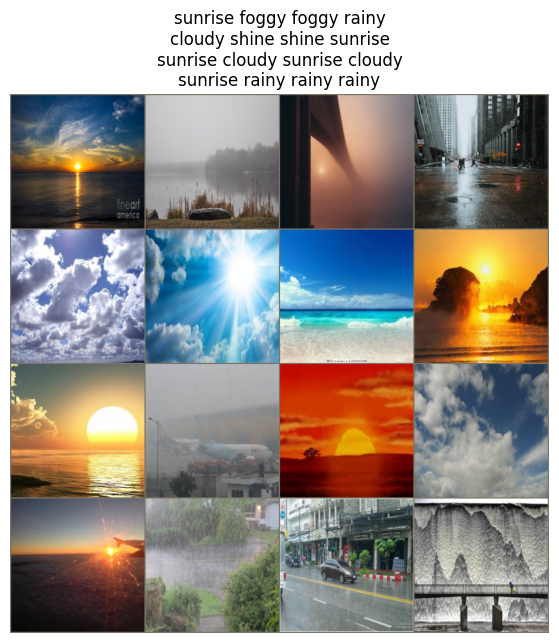

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# First, define the helper function to show images
def imshow(inp, title=None):
    """Helper function to display a batch of images"""
    # PyTorch tensors are C x H x W
    # Matplotlib expects H x W x C
    inp = inp.numpy().transpose((1, 2, 0))

    mean = np.array(IMAGENET_MEAN)
    std = np.array(IMAGENET_STD)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) # Ensure values are between 0 and 1

    # Plot the image
    plt.figure(figsize=(15, 7))
    plt.imshow(inp)
    if title:
        plt.title(title, fontsize=12)
    plt.axis('off')
    plt.show()

print("Fetching one batch of training images...")

inputs, classes = next(iter(train_loader))

inputs_16 = inputs[:16]
classes_16 = classes[:16]
out = torchvision.utils.make_grid(inputs_16, nrow=4)

title = [class_names[x] for x in classes_16]
title_str = "\n".join([" ".join(title[i:i+4]) for i in range(0, 16, 4)])

print("Displaying 4x4 grid (with augmentation)...")
imshow(out, title=title_str)

## Build model

In [ ]:
import torch.nn as nn
from torchvision import models

# --- 1. Load Pre-trained Base Model ---
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# --- 2. Freeze the Base Model Layers ---
for param in model.parameters():
    param.requires_grad = False

# --- 3. Create Your "Own Model" (The Head) ---
num_features = model.fc.in_features

model.fc = nn.Sequential(
    nn.Linear(num_features, 256),   # Input (512) -> Hidden Layer (256)
    nn.ReLU(),                      # Activation function
    nn.Dropout(0.5),                # Dropout to prevent overfitting
    nn.Linear(256, NUM_CLASSES)     # Hidden Layer (256) -> Output (4 classes)
)

# --- 4. Move Model to Device (GPU) ---
model = model.to(device)

# --- 5. Verify ---
print("--- Model Created ---")
print("Parameters to be trained:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"  {name}")

--- Model Created ---
Parameters to be trained:
  fc.0.weight
  fc.0.bias
  fc.3.weight
  fc.3.bias


## Defined loss function and optimizer

In [ ]:
import torch.optim as optim

# 1. Define Loss Function
criterion = nn.CrossEntropyLoss()

# 2. Define Optimizer
optimizer = optim.Adam(model.fc.parameters(), lr=0.0002)

# 3. (Optional) Learning Rate Scheduler
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

print("--- Loss Function and Optimizer Defined ---")
print(f"Optimizer will train {sum(p.numel() for p in model.fc.parameters())} parameters.")

--- Loss Function and Optimizer Defined ---
Optimizer will train 132870 parameters.


## Start Training loop

In [ ]:
import time

# --- 1. Create lists to store history ---
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

NUM_EPOCHS = 7

print(f"--- Starting Training for {NUM_EPOCHS} Epochs ---")

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()

    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    scheduler.step()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    # --- 2. Save training history ---
    train_loss_history.append(epoch_loss)
    train_acc_history.append(epoch_acc.cpu().item())

    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_acc = val_corrects.double() / len(val_dataset)

    # --- 3. Save validation history ---
    val_loss_history.append(epoch_val_loss)
    val_acc_history.append(epoch_val_acc.cpu().item())

    # Print results for this epoch
    epoch_time = time.time() - epoch_start_time
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f} | Time: {epoch_time:.2f}s")

print("--- Finished Training ---")

--- Starting Training for 7 Epochs ---
Epoch 1/7 | Train Loss: 1.4875 Acc: 0.4387 | Val Loss: 1.1498 Acc: 0.7320 | Time: 170.84s
Epoch 2/7 | Train Loss: 1.0370 Acc: 0.7296 | Val Loss: 0.8023 Acc: 0.8431 | Time: 157.47s
Epoch 3/7 | Train Loss: 0.7876 Acc: 0.7998 | Val Loss: 0.6118 Acc: 0.9085 | Time: 166.52s
Epoch 4/7 | Train Loss: 0.6351 Acc: 0.8489 | Val Loss: 0.5196 Acc: 0.9020 | Time: 160.35s
Epoch 5/7 | Train Loss: 0.5592 Acc: 0.8603 | Val Loss: 0.4701 Acc: 0.8987 | Time: 157.15s
Epoch 6/7 | Train Loss: 0.4986 Acc: 0.8766 | Val Loss: 0.4074 Acc: 0.9183 | Time: 157.61s
Epoch 7/7 | Train Loss: 0.4325 Acc: 0.8954 | Val Loss: 0.3862 Acc: 0.9216 | Time: 157.32s
--- Finished Training ---


## Show loss function graph

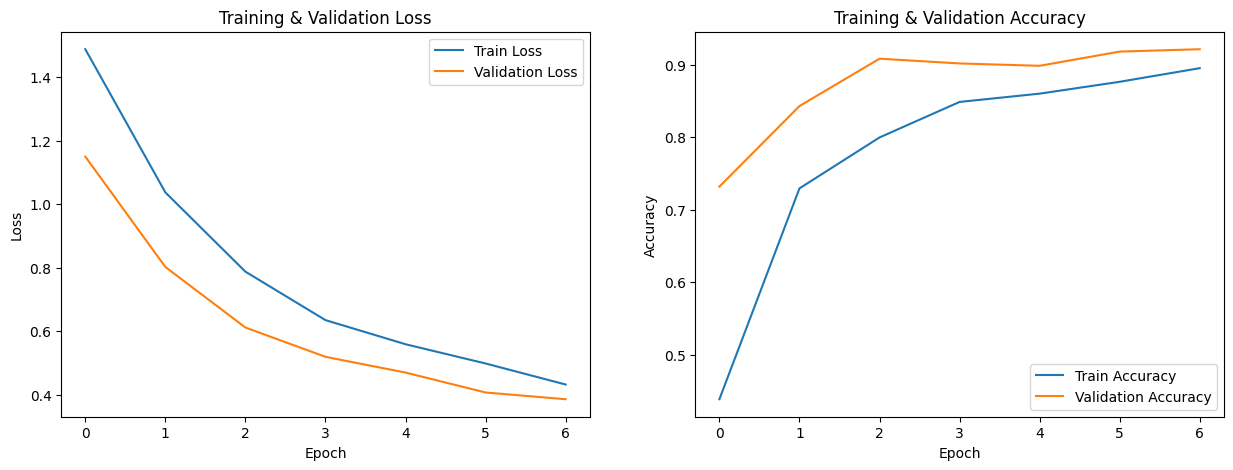

In [ ]:
import matplotlib.pyplot as plt

# --- Create a 1x2 grid of plots ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# --- Plot 1: Loss ---
ax1.plot(train_loss_history, label='Train Loss')
ax1.plot(val_loss_history, label='Validation Loss')
ax1.set_title('Training & Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# --- Plot 2: Accuracy ---
ax2.plot(train_acc_history, label='Train Accuracy')
ax2.plot(val_acc_history, label='Validation Accuracy')
ax2.set_title('Training & Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

# --- Show the plots ---
plt.show()

## Show Accuracy

--- Evaluating Model on Validation Set ---

--- Classification Report ---
              precision    recall  f1-score   support

  alien_test       0.00      0.00      0.00         6
      cloudy       0.85      0.95      0.90        55
       foggy       0.96      0.93      0.95        58
       rainy       0.95      0.95      0.95        64
       shine       0.87      0.87      0.87        45
     sunrise       0.95      0.97      0.96        78

    accuracy                           0.92       306
   macro avg       0.76      0.78      0.77       306
weighted avg       0.90      0.92      0.91       306


--- Generating Confusion Matrix ---


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


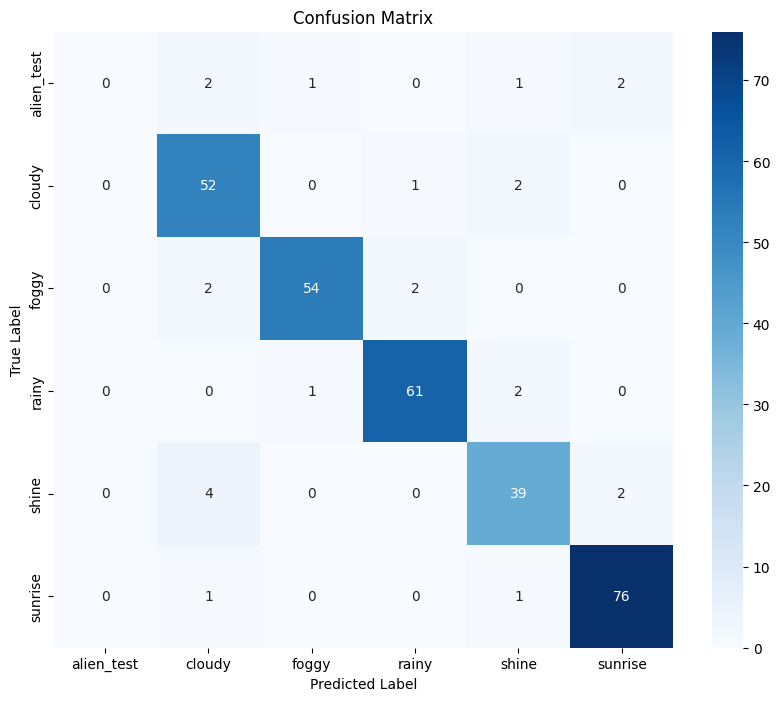

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

print("--- Evaluating Model on Validation Set ---")
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch predictions and labels to the lists
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- 1. Print Classification Report ---
print("\n--- Classification Report ---")
report = classification_report(all_labels, all_preds, target_names=class_names)
print(report)


# --- 2. Plot Confusion Matrix ---
print("\n--- Generating Confusion Matrix ---")
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# Save the trained model weights
model_save_path = "weather_classifier_resnet18_v1.pth"
torch.save(model.state_dict(), model_save_path)

print(f"\n--- Model Saved ---")
print(f"Model weights saved to: {model_save_path}")


--- Model Saved ---
Model weights saved to: weather_classifier_resnet18_v1.pth
